In [80]:
# python
import sys
import os
import importlib
# columnar analysis
import awkward as ak
from dask.distributed import Client
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import sidm_processor, utilities, cutflow, scaleout
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
importlib.reload(scaleout)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

In [81]:
#fname = '~/local_data/tta_mAlp-0p35GeV_ctau-1e3mm_part-0.root'
samples = [
    "4mu_500GeV_5GeV_0p08mm", # ~134,000 events (weighted and unweighted)
    #"4mu_500GeV_5GeV_0p8mm",
    #"4mu_500GeV_5GeV_8p0mm",
    #"4mu_500GeV_5GeV_40p0mm",
    #"4mu_500GeV_5GeV_80p0mm",
]
fileset = utilities.make_fileset(samples, "llpNanoAOD_v1")
# create events collection from single file
fname = fileset[samples[0]][0]
print(fname)
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=NanoAODSchema,
).events()

2024-06-17 20:37:24,863 - distributed.utils_perf - INFO - full garbage collection released 10.78 MiB from 261771 reference cycles (threshold: 9.54 MiB)


root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/LLPNanoAOD/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08/LLPnanoAOD/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08_part-0.root


In [82]:
#ak.fields(events)

In [83]:
#/store/group/lpcmetx/SIDM/ULSignalSamples/2018_v3/signals/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08/LLPnanoAOD/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08_part-0.rootak.fields(events.Muon)

In [84]:
print(events.PV.fields)
print(events.PV.pos.rho)
print(events.PV)
print(events.PV.npvs)

['ndof', 'x', 'y', 'z', 'chi2', 'score', 'npvs', 'npvsGood']
[2.66, 0.682, 3.2, 4.04, 0.969, 1.89, 0.113, ... 3.4, 0.223, 4.48, 2.73, 2.28, 5.54]
[Vertex, Vertex, Vertex, Vertex, Vertex, ... Vertex, Vertex, Vertex, Vertex, Vertex]
[38, 34, 19, 28, 23, 23, 22, 14, 36, 7, ... 36, 35, 28, 22, 37, 31, 21, 24, 31, 21]


In [85]:
print(events.GenPart.fields)
print(events.GenPart.pdgId)
print(ak.num(events.GenPart[abs(events.GenPart.pdgId)==13]))
print(ak.num(events.GenPart[abs(events.GenPart.pdgId)==32]))
print(events.GenPart[abs(events.GenPart.pdgId)==32].children.pdgId)
print(abs(events.GenPart[abs(events.GenPart.pdgId)==32].children.pdgId) == 13)
print(abs(events.GenPart.pdgId))
print(ak.all(abs(events.GenPart[events.GenPart.pdgId==32].children.pdgId) == 13, axis=-1))
print(events.GenPart[(abs(events.GenPart.pdgId)== 32) & ak.all(abs(events.GenPart.children.pdgId) == 13, axis=-1)])

['eta', 'mass', 'phi', 'pt', 'genPartIdxMother', 'pdgId', 'status', 'statusFlags', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'genPartIdxMotherG', 'distinctParentIdxG', 'childrenIdxG', 'distinctChildrenIdxG', 'distinctChildrenDeepIdxG']
[[-4, 4, 35, 35, 32, 32, -13, 13, -13, ... 1, -1, -421, 11, -11, 11, -11, 11, -11]]
[4, 4, 6, 8, 6, 9, 4, 6, 4, 6, 6, 7, 5, 7, ... 6, 6, 4, 4, 6, 6, 5, 4, 4, 4, 8, 5, 6]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[[[-13, 13], [-13, 13]], [[-13, 13], [-13, ... [-13, 13]], [[-13, 13], [-13, 13]]]
[[[True, True], [True, True]], [[True, ... True]], [[True, True], [True, True]]]
[[4, 4, 35, 35, 32, 32, 13, 13, 13, 13, ... 1, 1, 1, 421, 11, 11, 11, 11, 11, 11]]
[[True, True], [True, True], [True, True, ... True], [True, True], [True, True]]
[[GenParticle, GenParticle], [GenParticle, ... [GenParticle, GenParticle]]


In [86]:
print(events.GenPart)

[[GenParticle, GenParticle, GenParticle, ... GenParticle, GenParticle, GenParticle]]


In [87]:
#events.Electron.fields

In [88]:
events[ak.num(events.Electron)>0].Electron.vidNestedWPBitmap

<Array [[613550372], ... [605029924]] type='119 * var * int32[parameters={"__doc...'>

In [89]:
#events.DSAMuon.fields

In [90]:
print(events.DSAMuon.muonMatch1)
#print(events.DSAMuon.nSegments)
print(ak.num(events.DSAMuon))
#print(ak.num(events.DSAMuon[events.DSAMuon.muonMatch1/events.DSAMuon.nSegments < 0.667]))

[[2, 3, 2], [6, 5, 0, 7, 0, 0], [3, 0, 0, 4, ... 1], [2, 2], [4, 4, 2, 1], [4, 3, 2]]
[3, 6, 6, 6, 8, 4, 3, 2, 3, 4, 6, 4, 5, 4, ... 5, 5, 5, 2, 4, 6, 2, 5, 3, 6, 2, 4, 3]


In [91]:
#print(events.DSAMuon.muonMatch1[0])
print(set(ak.flatten(events.DSAMuon.muonMatch1idx)))
print(events.DSAMuon[0])
print(events.Muon[0])
print(events.Muon[ak.values_astype(events.DSAMuon.muonMatch1idx, "int64")])
a = ak.Array([[0, 1, 0], [1]])
b = ak.Array([[71, 72], [59, 58, 57]])
b[a]

{0.0, 1.0, 2.0, 3.0, 4.0}
[{idx: 0, pt: 109, ptErr: 48.2, eta: 0.848, ... muonMatch5: -1, muonMatch5idx: -1}]
[Muon, Muon, Muon, Muon]
[[Muon, Muon, Muon], [Muon, Muon, Muon, ... Muon, Muon, Muon], [Muon, Muon, Muon]]


<Array [[71, 72, 71], [58]] type='2 * var * int64'>

In [92]:
print(events.DSAMuon.muonMatch1)
print(events.DSAMuon.muonMatch1idx)
print(ak.flatten(events.DSAMuon.muonMatch1idx))
#print(events.DSAMuon.outerPhi)
print(events.Muon.outerPhi)
print(events.Muon[ak.values_astype(events.DSAMuon.muonMatch1idx, "int64")].outerPhi)
utilities.dR_outer(events.DSAMuon, events.Muon[ak.values_astype(events.DSAMuon.muonMatch1idx, "int64")])

[[2, 3, 2], [6, 5, 0, 7, 0, 0], [3, 0, 0, 4, ... 1], [2, 2], [4, 4, 2, 1], [4, 3, 2]]
[[0, 1, 3], [1, 4, 4, 0, 4, 4], [2, 3, 3, 1, ... 2], [2, 0], [3, 0, 2, 1], [2, 3, 0]]
[0, 1, 3, 1, 4, 4, 0, 4, 4, 2, 3, 3, 1, 0, ... 1, 3, 0, 2, 2, 0, 3, 0, 2, 1, 2, 3, 0]
[[0.181, -2.98, 0.172, -2.97], [1.3, -1.83, ... 2.55], [2.59, -0.458, -0.462, 2.65]]
[[0.181, -2.98, -2.97], [-1.83, 1.47, 1.47, ... -2.08, -2], [-0.462, 2.65, 2.59]]


<Array [[0.000255, 0.000276, ... 0.131]] type='817 * var * float32'>

In [93]:
#from coffea.nanoevents.schemas.base import zip_forms
from coffea.nanoevents.methods import vector as cvec
from coffea.nanoevents.methods import nanoaod
#print(events.Muon)
#print([events.DSAMuon[x] for x in ["pt", "eta"]])
print(events.DSAMuon)
forms = {f : events.DSAMuon[f] for f in events.DSAMuon.fields}
events.DSAMuon = ak.zip(forms, with_name="Muon", behavior=nanoaod.behavior)
print(events.DSAMuon)
print(events.DSAMuon.nearest(events.Muon))

[[{idx: 0, pt: 109, ptErr: 48.2, eta: 0.848, ... muonMatch5: -1, muonMatch5idx: -1}]]
[[Muon, Muon, Muon], [Muon, Muon, Muon, ... Muon, Muon, Muon], [Muon, Muon, Muon]]
[[Muon, Muon, Muon], [Muon, Muon, Muon, ... Muon, Muon, Muon], [Muon, Muon, Muon]]


In [94]:
runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    #executor=processor.DaskExecutor(),
    #executor=processor.FuturesExecutor(),
    schema=NanoAODSchema,
    # maxchunks=1,
)

hist_menu = utilities.load_yaml("../configs/hist_collections.yaml")
hist_choice = "base"
collection = utilities.flatten(hist_menu[hist_choice]) #To change the histograms used, swap "base" for the other collections

p = sidm_processor.SidmProcessor(
    [
        "baseNoLj",
        #"barrelE_ID-DPhiIn",
    ],
    [hist_choice],
    lj_reco_choices=["0.4"],
    llpnanoaod=True,
)

output = runner.run(fileset, treename='Events', processor_instance=p)
out = output["out"]

Output()

2024-06-17 20:37:32,210 - distributed.utils_perf - INFO - full garbage collection released 11.39 MiB from 130298 reference cycles (threshold: 9.54 MiB)
2024-06-17 20:37:34,851 - distributed.utils_perf - INFO - full garbage collection released 47.06 MiB from 390885 reference cycles (threshold: 9.54 MiB)
2024-06-17 20:37:38,453 - distributed.utils_perf - INFO - full garbage collection released 45.39 MiB from 390885 reference cycles (threshold: 9.54 MiB)
2024-06-17 20:37:40,797 - distributed.utils_perf - INFO - full garbage collection released 24.68 MiB from 260590 reference cycles (threshold: 9.54 MiB)
2024-06-17 20:37:43,977 - distributed.utils_perf - INFO - full garbage collection released 63.56 MiB from 521180 reference cycles (threshold: 9.54 MiB)
2024-06-17 20:37:46,388 - distributed.utils_perf - INFO - full garbage collection released 23.64 MiB from 260590 reference cycles (threshold: 9.54 MiB)
2024-06-17 20:37:49,516 - distributed.utils_perf - WARNING - full garbage collections to

Output()

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:38:55,355 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-06-17 20:38:55,355 - distributed.utils_perf - INFO - full garbage collection released 27.62 MiB from 397954 reference cycles (threshold: 9.54 MiB)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:00,278 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-06-17 20:39:00,279 - distributed.utils_perf - INFO - full garbage collection released 30.03 MiB from 411709 reference cycles (threshold: 9.54 MiB)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:04,151 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:09,232 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-06-17 20:39:09,232 - distributed.utils_perf - INFO - full garbage collection released 14.23 MiB from 274540 reference cycles (threshold: 9.54 MiB)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:14,328 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-06-17 20:39:14,329 - distributed.utils_perf - INFO - full garbage collection released 35.97 MiB from 541361 reference cycles (threshold: 9.54 MiB)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:18,262 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:23,200 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2024-06-17 20:39:23,201 - distributed.utils_perf - INFO - full garbage collection released 12.75 MiB from 407948 reference cycles (threshold: 9.54 MiB)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:28,044 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2024-06-17 20:39:28,045 - distributed.utils_perf - INFO - full garbage collection released 11.54 MiB from 278329 reference cycles (threshold: 9.54 MiB)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:32,135 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:37,103 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2024-06-17 20:39:37,104 - distributed.utils_perf - INFO - full garbage collection released 16.52 MiB from 407983 reference cycles (threshold: 9.54 MiB)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:41,996 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:45,973 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:50,848 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:55,015 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:39:59,767 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:04,810 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2024-06-17 20:40:04,810 - distributed.utils_perf - INFO - full garbage collection released 15.43 MiB from 411689 reference cycles (threshold: 9.54 MiB)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:09,360 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:14,305 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:19,683 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-06-17 20:40:19,684 - distributed.utils_perf - INFO - full garbage collection released 13.03 MiB from 411705 reference cycles (threshold: 9.54 MiB)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:24,474 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:28,455 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:33,189 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-06-17 20:40:33,189 - distributed.utils_perf - INFO - full garbage collection released 10.68 MiB from 411727 reference cycles (threshold: 9.54 MiB)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:37,864 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:41,637 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:46,374 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:50,424 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:55,055 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

2024-06-17 20:40:59,827 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-06-17 20:40:59,828 - distributed.utils_perf - INFO - full garbage collection released 14.19 MiB from 407890 reference cycles (threshold: 9.54 MiB)


Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

Not applying any cuts to the lepton jets for channel baseNoLj

Warning: Unable to apply no PF match for dsaMuons. Skipping.

Uh oh, haven't evaluated this cut yet! Make sure it was included in the list of cuts you used to initialize this 
JaggedSelection.   dsaMuons :  no PF match

Applying cut:  PV filter

In [95]:
#This defines a function to break down the samples and make individual subplots for each one.
#Fix: should set the specific range as a parameter. For now, it uses [ :1200j]. Could be an issue in the future.
def plotSamples(hists, channel, errorBars, densityPlot, sample_0=samples, fullBg=False):
    samples = []
    if channel == "2mu2e":
        for sample in sample_0:
            if sample[0] != '4':
                samples.append(sample)
    elif channel == "4mu":
        for sample in sample_0:
            if sample[0] != '2':
                samples.append(sample)
    else:
        for sample in sample_0:
            samples.append(sample)
    nplots = len(samples)
    nhists = len(hists)
    if (nplots <= 6): ncol, nrow = nplots, 1
    else: ncol, nrow = 6, (nplots-1)//6 + 1
    plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
    plt.rcParams['font.size'] = 16
    DY_Flag = QCD_Flag = DB_Flag = TT_Flag = Tot_BG_Flag = False
    Tot_BG_Flag = not fullBg
    for i in range(nplots):
        plt.subplot(nrow, ncol, i+1)
        j = 0
        if "DY_Jets" in samples and DY_Flag == False:
            for j in range(nhists):
                utilities.plot(DY_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DY_Flag = True
        elif "QCD_Jets" in samples and QCD_Flag == False:
            for j in range(nhists):
                utilities.plot(QCD_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                QCD_Flag = True
        elif "DiBoson_Jets" in samples and DB_Flag == False:
            for j in range(nhists):
                utilities.plot(DiBoson_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DB_Flag = True
        elif "TTJets" in samples and TT_Flag == False:
            for j in range(nhists):
                utilities.plot(TT_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                TT_Flag = True
        elif "Total Background" in samples and Tot_BG_Flag == False:
            for j in range(nhists):
                utilities.plot(bg_Hists[hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                Tot_BG_Flag = True
        else:
            for j in range(nhists):
                utilities.plot(out[samples[i]]["hists"][hists[j]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
        plt.legend(hists)
        plt.title(samples[i])

In [96]:
#This function plots each histogram on a separate subplot, showing all samples on each subplot
def plotHists(hists, channel, errorBars, densityPlot, sample_0=samples, fullBg=False):
    samples = []
    if channel == "2mu2e":
        for sample in sample_0:
            if sample[0] != '4':
                samples.append(sample)
    elif channel == "4mu":
        for sample in sample_0:
            if sample[0] != '2':
                samples.append(sample)
    else:
        for sample in sample_0:
            samples.append(sample)
    nplots = len(hists)
    if (nplots <= 5): ncol, nrow = nplots, 1
    else: ncol, nrow = 4, (nplots-1)//4 + 1
    plt.subplots(nrow, ncol, figsize=(ncol*12, nrow*9))
    plt.rcParams['font.size'] = 16
    for i in range(nplots):
        DY_Flag = QCD_Flag = DB_Flag = TT_Flag = Tot_BG_Flag = False
        plt.subplot(nrow, ncol, i+1)
        j = 0
        while j < len(samples):
            if "DY_Jets" in samples and DY_Flag == False:
                utilities.plot(DY_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DY_Flag = True
            elif "QCD_Jets" in samples and QCD_Flag == False:
                utilities.plot(QCD_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                QCD_Flag = True
            elif "DiBoson_Jets" in samples and DB_Flag == False:
                utilities.plot(DiBoson_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                DB_Flag = True
            elif "TTJets" in samples and TT_Flag == False:
                utilities.plot(TT_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                TT_Flag = True
            elif "Total Background" in samples and Tot_BG_Flag == False:
                utilities.plot(bg_Hists[hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
                Tot_BG_Flag = True
            else:
                utilities.plot(out[samples[j]]["hists"][hists[i]][channel, :], yerr=errorBars, density=densityPlot, flow='none')
            j = j + 1
        plt.legend(samples)
        plt.title(hists[i])

In [97]:
hists = out[samples[0]]["hists"]

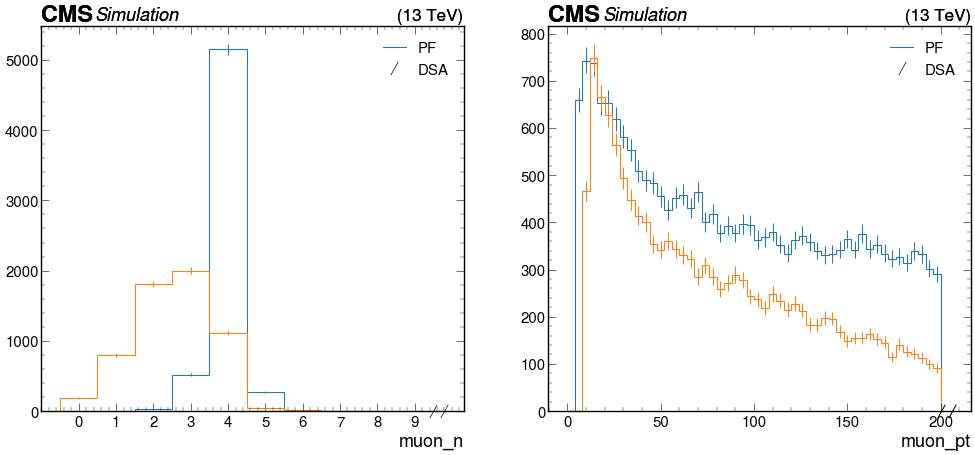

In [98]:
plt.subplots(1, 2, figsize=(24, 10))
plt.subplot(1, 2, 1)
utilities.plot(hists["muon_n"]["baseNoLj", :])
utilities.plot(hists["dsaMuon_n"]["baseNoLj", :])
plt.legend(["PF", "DSA"])
plt.subplot(1, 2, 2)
utilities.plot(hists["muon_pt"]["baseNoLj", ::2j])
utilities.plot(hists["dsaMuon_pt"]["baseNoLj", ::2j])
plt.legend(["PF", "DSA"])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fdc41288ca0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

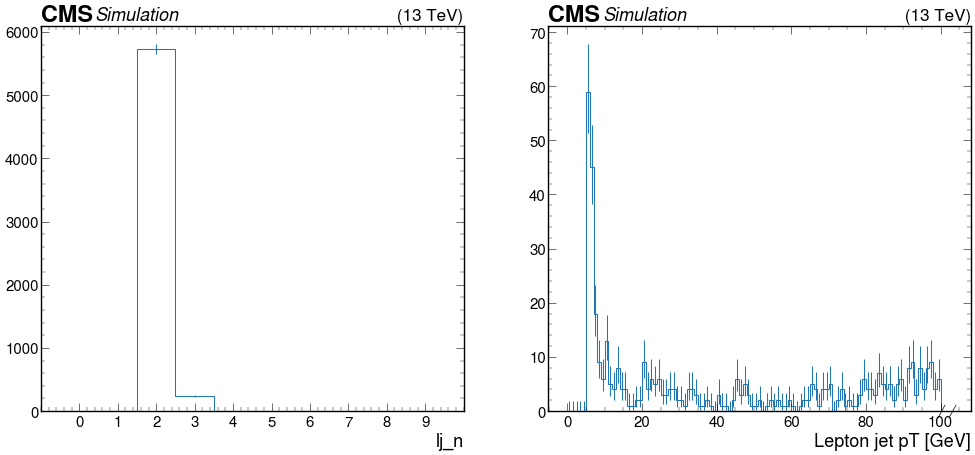

In [99]:
plt.subplots(1, 2, figsize=(24, 10))
plt.subplot(1, 2, 1)
utilities.plot(hists["lj_n"]["baseNoLj", :])
plt.subplot(1, 2, 2)
utilities.plot(hists["lj_pt"]["baseNoLj", :])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fdc0621bd00>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

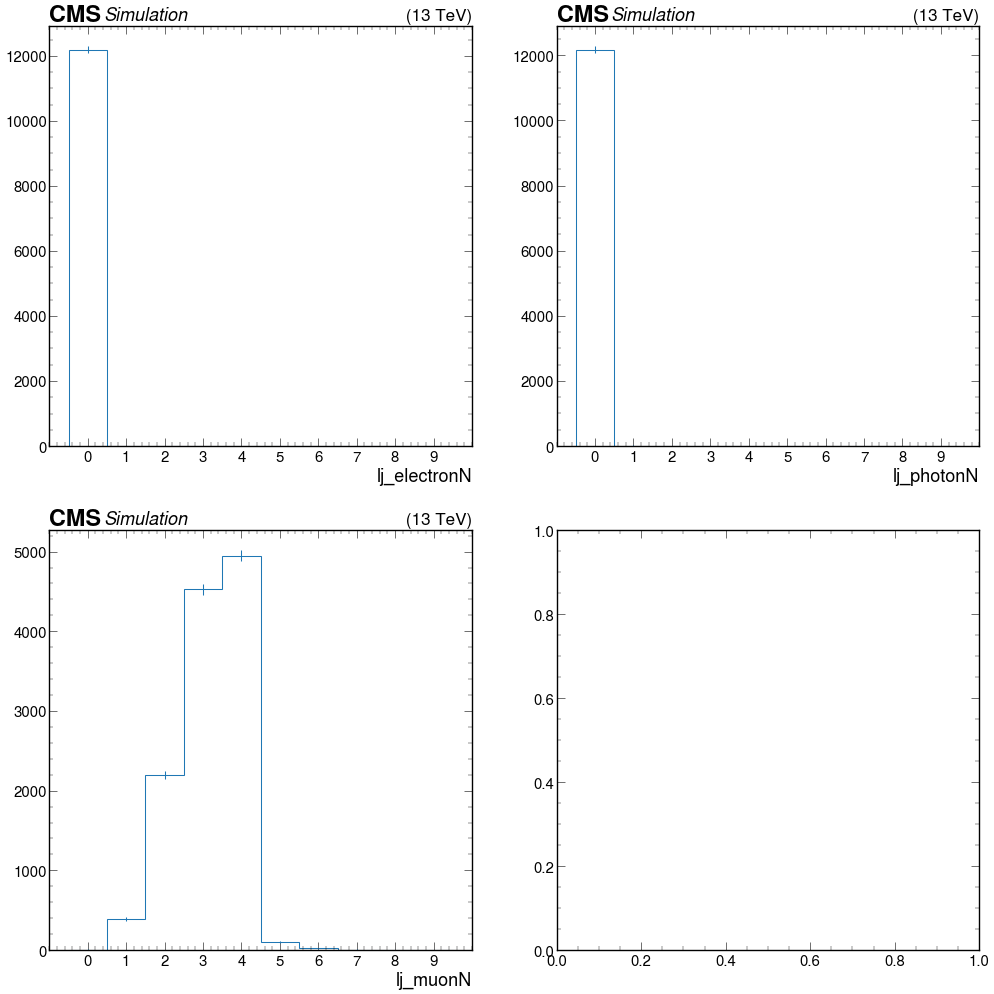

In [100]:
plt.subplots(2, 2, figsize=(24, 24))
plt.subplot(2, 2, 1)
utilities.plot(hists["lj_electronN"]["baseNoLj", :])
plt.subplot(2, 2, 2)
utilities.plot(hists["lj_photonN"]["baseNoLj", :])
plt.subplot(2, 2, 3)
utilities.plot(hists["lj_muonN"]["baseNoLj", :])
#plt.subplot(2, 2, 4)
#utilities.plot(hists["lj_dsaMuonN"]["llpnano", :])

In [105]:
cutflows = []
for sample in samples:
    cutflows.append(out[sample]["cutflow"]["baseNoLj"])
cutflow.print_multi_table(cutflows, samples, False, False, "test")

test
---------------------------------
cut name                  Total cuts:
                4mu_500GeV_5GeV_0p08mm
------------  ------------------------
No selection                 134166.00
PV filter                      5972.00



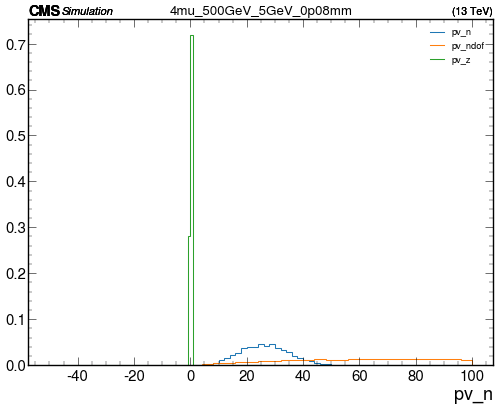

In [102]:
histlist = ["pv_n", "pv_ndof", "pv_z"]
plotSamples(histlist, "baseNoLj", False, True)

2024-06-17 20:41:16,515 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:262: RuntimeWarning: divide by zero encountered in double_scalars
  self.flat_scale(1 / np.sum(np.diff(self.edges) * self.values))
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:242: RuntimeWarning: invalid value encountered in multiply
  self.values *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:243: RuntimeWarning: invalid value encountered in multiply
  self.yerr_lo *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:244: RuntimeWarning: invalid value encountered in multiply
  self.yerr_hi *= scale
/opt/conda/lib/python3.9/site-packages/mplhep/utils.py:262: RuntimeWarni

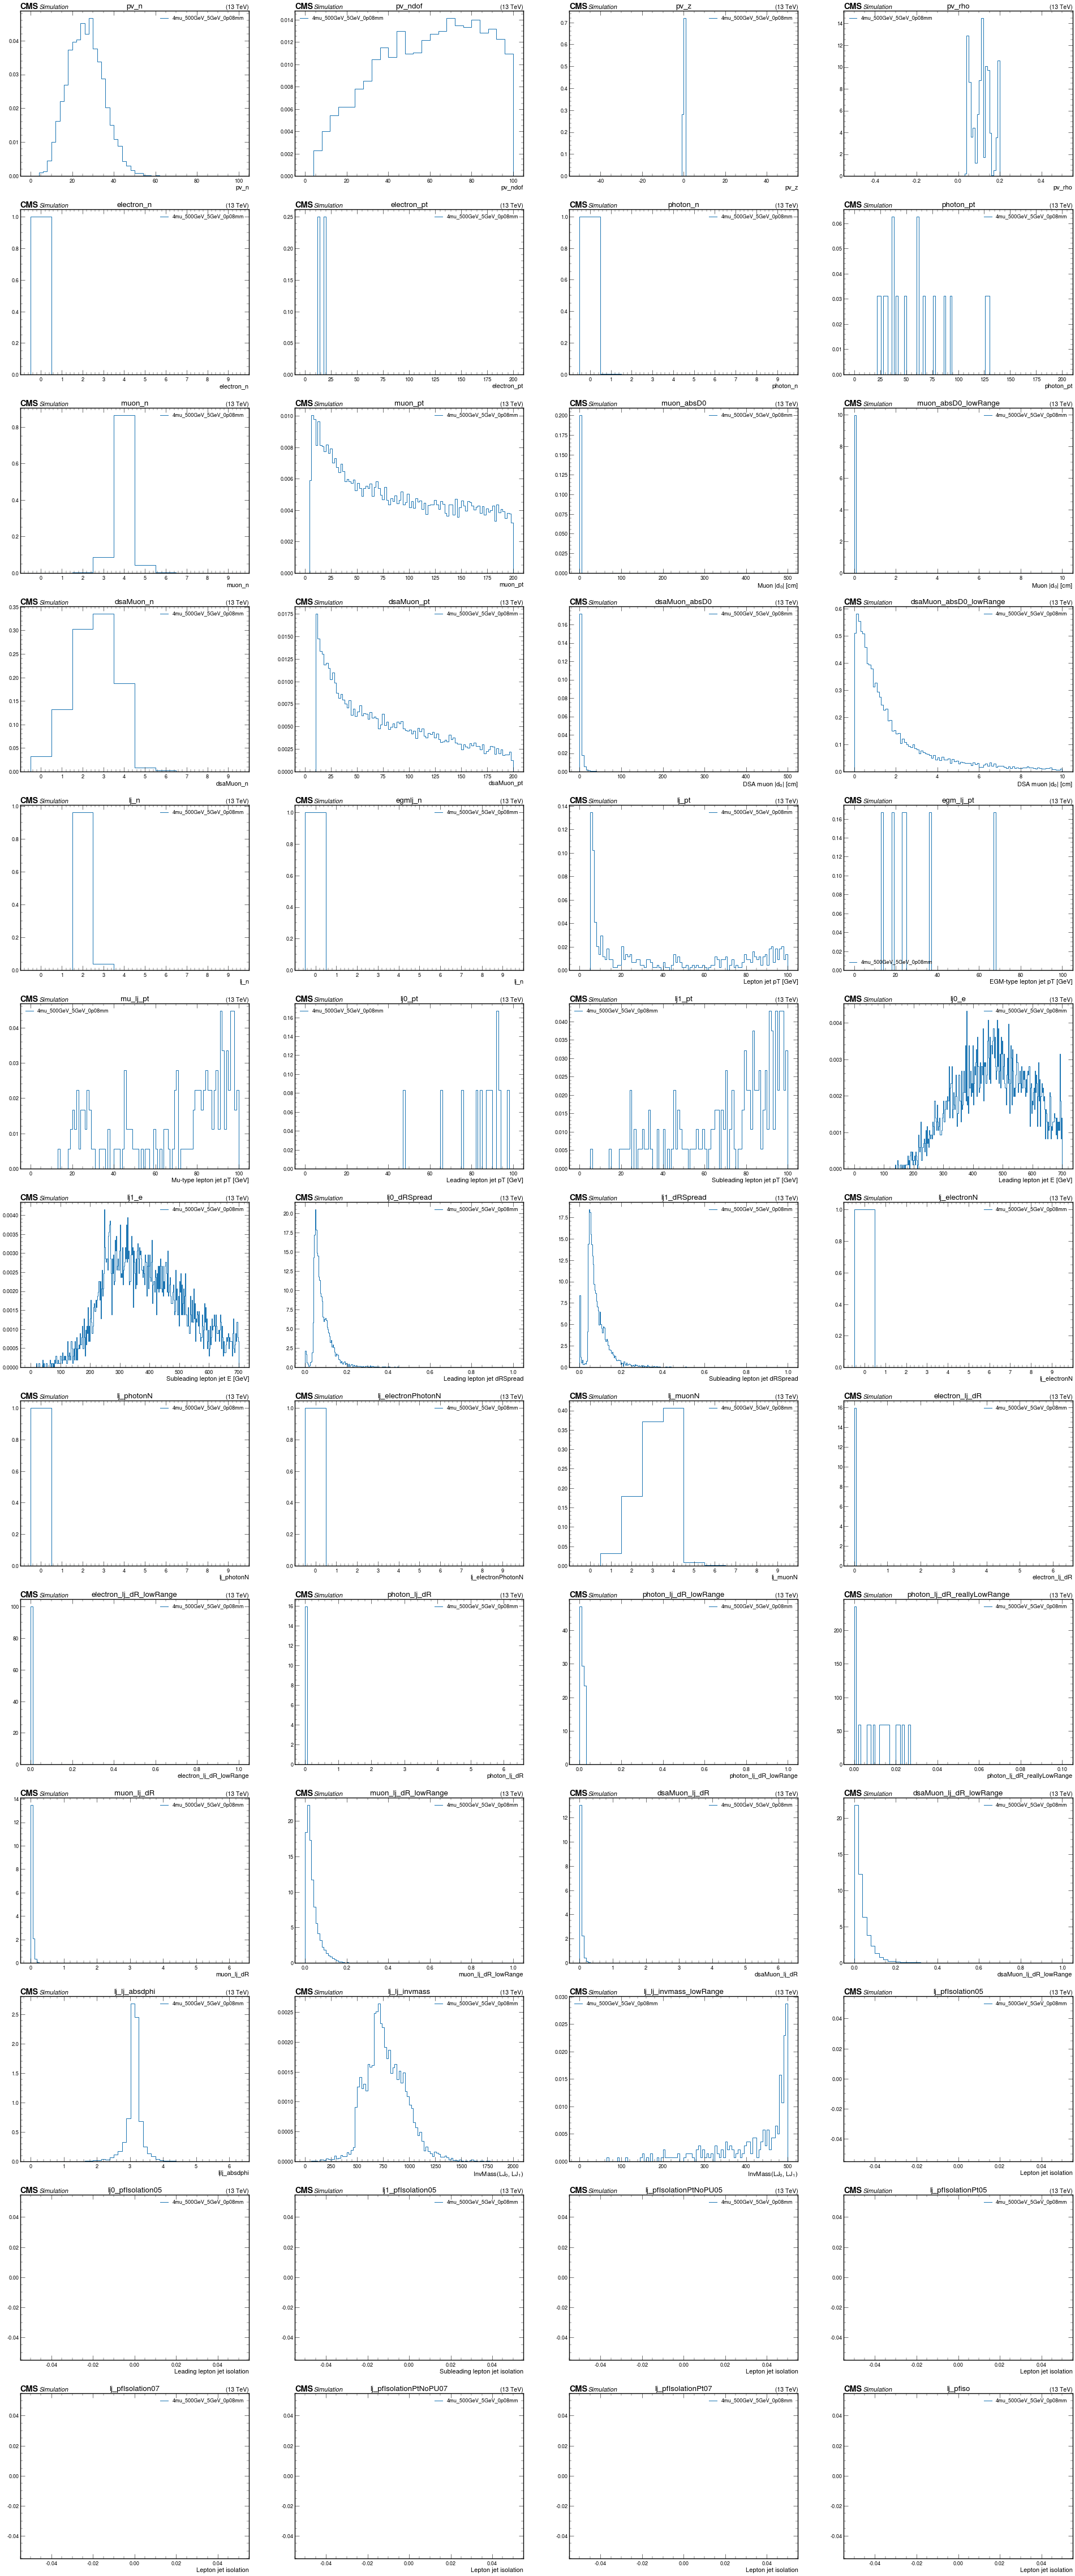

In [103]:
histlist = []
for hist in collection: 
    if "eta_phi" not in hist:
        histlist.append(hist)
histlist.remove("abcd_lj_lj_dphi_vs_lj0_pfIsolationPt05") #All removed histrograms returned a "wrong number of indices" error
plotHists(histlist, "baseNoLj", False, True)